In [ ]:
# Run once

# !ssh-keygen -t rsa -b 4096 -f /content/drive/MyDrive/ML_Sem3_Project/.ssh/id_rsa -N "" -q
# !cat /content/drive/MyDrive/ML_Sem3_Project/.ssh/id_rsa.pub

In [1]:
# Run everytime

from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.ssh
!cp /content/drive/MyDrive/ML_Sem3_Project/.ssh/id_rsa ~/.ssh/
!cp /content/drive/MyDrive/ML_Sem3_Project/.ssh/id_rsa.pub ~/.ssh/
!chmod 600 ~/.ssh/id_rsa
!ssh-keyscan github.com >> ~/.ssh/known_hosts

import os

repo_dir = "/content/ML_Project_2025"

if not os.path.exists(repo_dir):
  !git clone git@github.com:astroartics/ML_Project_2025.git {repo_dir}
else:
  %cd {repo_dir}
  !git pull

%cd {repo_dir}

Mounted at /content/drive
# github.com:22 SSH-2.0-aae3c6b
# github.com:22 SSH-2.0-aae3c6b
# github.com:22 SSH-2.0-aae3c6b
# github.com:22 SSH-2.0-aae3c6b
# github.com:22 SSH-2.0-aae3c6b
Cloning into '/content/ML_Project_2025'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 179 (delta 96), reused 126 (delta 43), pack-reused 0 (from 0)
Receiving objects: 100% (179/179), 1.64 MiB | 3.29 MiB/s, done.
Resolving deltas: 100% (96/96), done.
/content/ML_Project_2025


In [ ]:

# Run everytime

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nUsing device:", device, "\n")

checkpoint_path = "/content/drive/MyDrive/ML_Sem3_Project/preprocessed_data.pt"
checkpoint = torch.load(
    checkpoint_path,
    map_location = device,  # ensures safe loading on CPU/GPU
    weights_only = False
)

# --------------------------------

# 4. Extract Variables
vocab = checkpoint["vocab"]
inv_vocab = checkpoint["inv_vocab"]

# Move tensors to device
X_padded = checkpoint["X_padded"].to(device)  # PyTorch does not run natively on TPU, hence using T4 GPU
y_tensor = checkpoint["y_tensor"].to(device)

# DataFrame cannot move to device; it stays on CPU
data = checkpoint["data"]

print(data["moves"].head())

# --------------------------------

# 5. Status
print("\nLoaded checkpoint successfully.\n")
print("X_padded shape:", X_padded.shape)
print("y_tensor shape:", y_tensor.shape)
print("Example vocab size:", len(vocab))


Using device: cuda 



In [ ]:
# Push changes to GitHub

!git config --global user.email "joshisanjanana114@gmail.com"
!git config --global user.name "Sanjana"

!cp /content/drive/MyDrive/ML_Sem3_Project/BaselineLSTM.ipynb /content/ML_Project_2025/

!git add BaselineLSTM.ipynb
!git commit -m "Added Notebook"
!git push

[main 48441b7] Added Notebook
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite BaselineLSTM.ipynb (75%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 63.54 KiB | 10.59 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To github.com:astroartics/ML_Project_2025.git
   07cc921..48441b7  main -> main


In [ ]:
# Train/test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_padded,
    y_tensor,
    test_size = 0.2,  # 80-20 split
    random_state = 42,
    shuffle=True
)

X_train.shape, X_test.shape


(torch.Size([526703, 292]), torch.Size([131676, 292]))

In [ ]:
# PyTorch Datasets and DataLoaders

# Why these are needed:
'''
1) Data cannot be fed to the model directly, because the number of integers is huge.
2) It must be given to the model in batches.
3) A DataLoader iterates over these batches.
4) DataLoader handles batching, shuffling, and feeding the model (if batch size = 64, then taking 64 sequences for X and 64 labels for y)
5) DataLoader also uses multiple workers to load batches faster.
6) Dataset allows Python to treat the data like a list (shuffling indices, slicing samples, fetching mini-batches automatically)
7) Dataset is a wrapper that tells PyTorch "How to get the ith sample."
8) Dataset: Defines how to access each sample
   DataLoader: Defines how to group examples into batches efficiently during training
'''

from torch.utils.data import Dataset, DataLoader

# X and y are not converted to a new format, they are just wrapped and become accessible through the Dataset interface
# For example, before Dataset, we manually index
# sample_X = X_train[100]
# sample_y = y_train[100]
# but, after Dataset, DataLoader can automatically fetch train_ds[100] -> returns (X_train[100], y_train[100])
class ChessDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    # Returns one sample to the DataLoader when requested: DataLoader needs data to be wrapped in a Dataset to
    # access it one by one randomly to form batches.
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoaders

batch_size = 64

train_dataset = ChessDataset(X_train, y_train)
test_dataset  = ChessDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size = batch_size)


In [ ]:
# LSTM

import torch
import torch.nn as nn

# Defining the Baseline LSTM model
# Training time for 5 epochs using a GPU: ~15 minutes

class BaselineLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=1, padding_idx=0):
        super().__init__()
        # Embedding: converts token IDs -> dense vectors
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=padding_idx)
        # LSTM: processes sequence of embeddings
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        # Final linear layer to produce logits for each vocabulary token
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        # x: LongTensor of shape (batch_size, seq_len)
        emb = self.embedding(x)                     # -> (batch_size, seq_len, embed_dim)
        outputs, (h_n, c_n) = self.lstm(emb)        # outputs -> (batch_size, seq_len, hidden_dim)
                                                   # h_n -> (num_layers, batch_size, hidden_dim)
        last_hidden = outputs[:, -1, :]             # take output at last time-step -> (batch_size, hidden_dim)
        logits = self.fc(last_hidden)               # -> (batch_size, vocab_size)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(vocab)        # vocab from your preprocessing (includes PAD and UNK)
lstm_model = BaselineLSTM(vocab_size=vocab_size, embed_dim=128, hidden_dim=256, num_layers=1, padding_idx=vocab['<PAD>']).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab['<PAD>'])   # ignore pad index if used in targets (usually not)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

# Training loop
num_epochs = 5
lstm_train_losses = []

lstm_model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Move to device
        X_batch = X_batch.to(device)                   # (batch_size, seq_len), dtype=torch.long
        y_batch = y_batch.to(device)                   # (batch_size,), dtype=torch.long (class indices)

        optimizer.zero_grad()

        logits = lstm_model(X_batch)                        # (batch_size, vocab_size)
        loss = criterion(logits, y_batch)              # CrossEntropy expects (N, C) and targets (N,)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)    # sum-of-losses for averaging later

    avg_loss = total_loss / len(train_loader.dataset)
    lstm_train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}  Train loss: {avg_loss:.4f}")

# Predicting / decoding one example
lstm_model.eval()
with torch.no_grad():
    sample_X = X_test[0].unsqueeze(0).to(device)      # shape (1, seq_len)
    logits = lstm_model(sample_X)                          # (1, vocab_size)
    pred_id = logits.argmax(dim=-1).item()            # integer token id
    pred_move = inv_vocab[pred_id]                    # decode to SAN using your inv_vocab
    print("Predicted token id:", pred_id, "Predicted SAN:", pred_move)


Epoch 1/5  Train loss: 6.3864
Epoch 2/5  Train loss: 6.3653
Epoch 3/5  Train loss: 6.3593
Epoch 4/5  Train loss: 6.3574
Epoch 5/5  Train loss: 6.3561
Predicted token id: 24 Predicted SAN: O-O


In [ ]:
# Transformer
# Training time for 5 epochs using a GPU: ~30 minutes

import math
import torch
import torch.nn as nn

# Since trandformers have no notion of order, we must add positional encoding information
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        return x + self.pe[:, :x.size(1)]

class TransformerBaseline(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model=128,
        nhead=4,
        num_layers=2,
        dim_feedforward=512,
        dropout=0.1,
        padding_idx=0,
        max_len=5000
    ):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=d_model,
            padding_idx=padding_idx
        )

        self.positional_encoding = PositionalEncoding(d_model, max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True   # IMPORTANT: matches your (B, T, D)
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        """
        x: (batch_size, seq_len)
        """

        # Padding mask: True where PAD
        padding_mask = (x == vocab['<PAD>'])

        emb = self.embedding(x)                    # (B, T, D)
        emb = self.positional_encoding(emb)        # (B, T, D)

        out = self.transformer_encoder(
            emb,
            src_key_padding_mask=padding_mask
        )                                           # (B, T, D)

        # Take last non-pad token representation
        lengths = (~padding_mask).sum(dim=1) - 1   # (B,)
        last_hidden = out[torch.arange(out.size(0)), lengths]

        logits = self.fc(last_hidden)               # (B, vocab_size)
        return logits

# Instantiating model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformer_model = TransformerBaseline(
    vocab_size=len(vocab),
    d_model=128,
    nhead=4,
    num_layers=2,
    dim_feedforward=512,
    padding_idx=vocab['<PAD>']
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-4)

# Training loop (Same as LSTM)
num_epochs = 10
transformer_train_losses = []

transformer_model.train()
for epoch in range(num_epochs):
    total_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        logits = transformer_model(X_batch)
        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    transformer_train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}  Train loss: {avg_loss:.4f}")

# Predicting the next move
transformer_model.eval()
with torch.no_grad():
    sample_X = X_test[0].unsqueeze(0).to(device)
    logits = transformer_model(sample_X)
    pred_id = logits.argmax(dim=-1).item()
    pred_move = inv_vocab[pred_id]

    print("Predicted move:", pred_move)

Epoch 1/10  Train loss: 5.8541
Epoch 2/10  Train loss: 5.3133
Epoch 3/10  Train loss: 5.0747
Epoch 4/10  Train loss: 4.9151


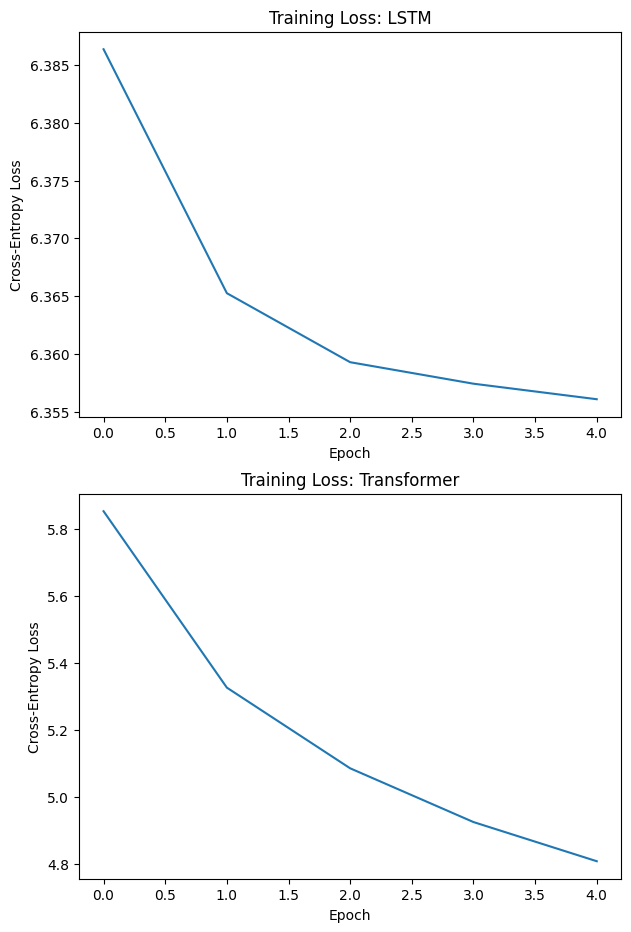

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 11))

plt.subplot(2, 1, 1)
plt.plot(lstm_train_losses, label="LSTM")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss: LSTM")

plt.subplot(2, 1, 2)
plt.plot(transformer_train_losses, label="Transformer")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss: Transformer")

plt.show()

In [ ]:
import chess
import chess.pgn
import urllib.parse
import webbrowser
from IPython.display import HTML, display

board = chess.Board()
game = chess.pgn.Game()
node = game
idx = 0  # First test example

def decode_sequence(x_tensor, inv_vocab, pad_id=0):
    # x_tensor: shape (seq_len,)
    moves = []
    for token_id in x_tensor.tolist():
        if token_id == pad_id:
            break
        moves.append(inv_vocab[token_id])
    return moves

san_moves = decode_sequence(X_test[idx], inv_vocab)

for san in san_moves:
    move = board.parse_san(san)
    board.push(move)
    node = node.add_variation(move)

# Now add predicted move
predicted_move = board.parse_san(pred_move)
board.push(predicted_move)
node.add_variation(predicted_move)

print(game[0])

pgn_str = str(game)
url = "https://lichess.org/analysis/pgn/" + urllib.parse.quote(pgn_str)
# print(url)

display(HTML(f'<a href="{url}" target="_blank">Open Lichess Analysis</a>'))

1. e4 e5 2. Bc4 Nc6 3. Nf3 h6 4. O-O Nf6 5. d4 Qe7 6. dxe5 Nxe4 7. Qd5 Nc5 8. Be3 b6 9. a3 d6 10. b4 Nxe5 11. bxc5 c6 12. Qxd6 Nxc4 13. Qxc6+ Qd7 14. Qxd7+


Expected move:  Qxa8


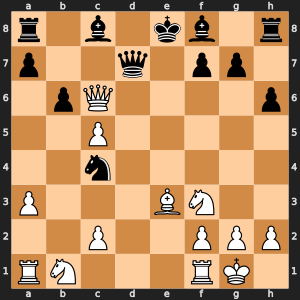

Transformer predicts: Qxd7+


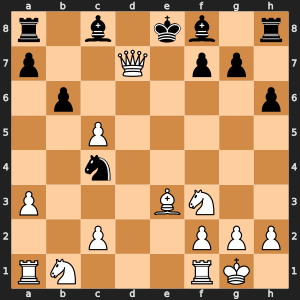

In [ ]:
# Chess game GUI (SVG)

import chess
import chess.svg
from IPython.display import SVG, display

def show_board(board, size=300):
    display(SVG(chess.svg.board(board=board, size=size)))

def predict_next_move(model, move_sequence, vocab, inv_vocab, device, top_k=1):
    """
    model        : trained LSTM or Transformer
    move_sequence: list of SAN moves, e.g. ["e4", "e5", "Nf3"]
    """

    model.eval()

    # Convert SAN moves → token IDs
    input_ids = [vocab.get(m, vocab['<UNK>']) for m in move_sequence]

    # Shape: (1, seq_len)
    x = torch.tensor(input_ids).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)              # (1, vocab_size)
        probs = torch.softmax(logits, dim=-1)

        if top_k == 1:
            pred_id = probs.argmax(dim=-1).item()
            return inv_vocab[pred_id]

        else:
            topk_ids = torch.topk(probs, top_k).indices.squeeze(0).tolist()
            return [inv_vocab[i] for i in topk_ids]


def encode_move_sequence(move_list, vocab, max_len):
    ids = [vocab.get(m, vocab['<UNK>']) for m in move_list]
    ids = ids[-max_len:]
    ids = [vocab['<PAD>']] * (max_len - len(ids)) + ids
    return torch.tensor(ids, dtype=torch.long)

board = chess.Board()
moves = ["e4", "e5", "Nf3", "Nc6"]
sequence_san = [
    inv_vocab[t.item()]
    for t in X_test[0]
    if t.item() != vocab['<PAD>']
]
sequence_san_y = [
    inv_vocab[t.item()]
    for t in y_test
    if t.item() != vocab['<PAD>']
]
print("Expected move: ", sequence_san_y[0])

for san in sequence_san:
    board.push_san(san)

show_board(board)

pred_move = predict_next_move(transformer_model, sequence_san, vocab, inv_vocab, device)
print("Transformer predicts:", pred_move)

try:
    board.push_san(pred_move)
    show_board(board)
except:
    print("Illegal move predicted")

In [ ]:
# fen = board.fen()
# print(fen)

# import webbrowser

# url = f"https://lichess.org/analysis/{fen.replace(' ', '_')}"
# webbrowser.open(url)

# def decode_sequence(x_tensor, inv_vocab, pad_id=0):
#     # x_tensor: shape (seq_len,)
#     moves = []
#     for token_id in x_tensor.tolist():
#         if token_id == pad_id:
#             break
#         moves.append(inv_vocab[token_id])
#     return moves

# idx = 0  # take first test example
# san_moves = decode_sequence(X_test[idx], inv_vocab)
# print(san_moves)

# def san_list_to_pgn(san_moves):
#     pgn = []
#     move_num = 1
#     for i in range(0, len(san_moves), 2):
#         if i + 1 < len(san_moves):
#             pgn.append(f"{move_num}. {san_moves[i]} {san_moves[i+1]}")
#         else:
#             pgn.append(f"{move_num}. {san_moves[i]}")
#         move_num += 1
#     return " ".join(pgn)

# pgn_moves = san_list_to_pgn(san_moves)
# print(pgn_moves)

# import urllib.parse

# encoded_pgn = urllib.parse.quote(pgn_moves)
# url = f"https://lichess.org/analysis/pgn/{encoded_pgn}"
# webbrowser.open(url)

# from IPython.display import HTML, display

# display(HTML(f'<a href="{url}" target="_blank">Open Lichess Analysis</a>'))